In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import sys

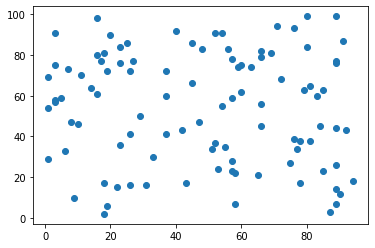

In [42]:
n=100
# n - кол-во рандомных точек
k=5
# k - кластеры
x = np.random.randint(1,100,n)
y = np.random.randint(1,100,n)
# plt.figure()
plt.scatter(x,y)
plt.show()

In [43]:
# Найдем расстояние между 2 точками
def dist(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2+(y1-y2)**2)

# Находим центр окружности, среднее арифметическое
# Найдем самую дальнюю точку, окружность будет располагаться на ней
def centers_init(x, y, k):
    x_cc = np.mean(x)
    y_cc = np.mean(y)
    R = max(dist(x[i], y[i], x_cc, y_cc) for i in range(n))
    x_c, y_c = [], []
    for i in range(k):
        x_c.append(R * np.cos(2 * np.pi * i / k) + x_cc)
        y_c.append(R * np.sin(2 * np.pi * i / k) + y_cc)
    return x_c, y_c

# график кластеров и их центров
def draw_c(df, x_column, y_column, cluster_column, x_c, y_c, title):
    facet = sns.lmplot(data=df, x=x_column, y=y_column, hue=cluster_column, 
                   fit_reg=False, legend=True, legend_out=True)
    plt.scatter(x_c, y_c, s=150, marker='X')
    plt.title(title)
    
# Найдем сумму квадратов расстояний от точек до центров их классов 
def sum_sqr(k, df, x_c, y_c):
    j = 0
    for c in range(k):
        for i in range(len(x)):
            if df['cluster'][i] == c:
                j += dist(df['x'][i], df['y'][i], x_c[c], y_c[c])**2
    return j

# Построим кластеры
def cluster(k, x, y, x_c, y_c):
    clusters = []
    for i in range(len(x)):
        min_dist = dist(x[i], y[i], x_c[0], y_c[0])
        min_num = 0
        for j in range(1, k):
            if min_dist > dist(x[i], y[i], x_c[j], y_c[j]):
                min_dist = dist(x[i], y[i], x_c[j], y_c[j])
                min_num = j
        clusters.append(min_num)
    return clusters

# Перерасчитаем центры кластеров
def centers_c(x, y, x_c, y_c, clust, k):
    for i in range(k):
        n = sum(el == i for el in clust)
        sum_x = sum(x[j] for j in range(len(clust)) if clust[j] == i)
        sum_y = sum(y[j] for j in range(len(clust)) if clust[j] == i)
        x_c[i] = sum_x / n if n != 0 else 0
        y_c[i] = sum_y / n if n != 0 else 0

In [44]:
def kmeans(k, x, y, sh_grph=True):
    n = len(x)
    df = pd.DataFrame()
    df['x'] = x
    df['y'] = y
    df['cluster'] = [0] * n
    x_c, y_c = centers_init(df['x'], df['y'], k)
    while True:
        clusters = cluster(k, df['x'], df['y'], x_c, y_c)
        if np.array_equal(clusters, df['cluster']):
            if sh_grph: draw_c(df, 'x', 'y', 'cluster', x_c, y_c, 'Распределение точек по кластерам')
            break
        else:
            df['cluster'] = clusters
            centers_c(df['x'], df['y'], x_c, y_c, clusters, k)
    return df, x_c, y_c

# Выберем число кластеров
def cluster_count(x, y, alpha):
    df, x_c, y_c = kmeans(1, x, y, False)
    j_pp = sum_sqr(1, df, x_c, y_c)
    df, x_c, y_c = kmeans(2, x, y, False)
    j_p = sum_sqr(2, df, x_c, y_c)
    for k in range(3, len(x)):
        df, x_c, y_c = kmeans(k, x, y, False)
        j = sum_sqr(k, df, x_c, y_c)
        if np.abs((j_p - j)/(j_pp - j_p)) < alpha:
            print('Оптимальное число кластеров при альфа = {0} равно {1}'.format(alpha, k - 1))
            kmeans(k - 1, x, y)
            return
        j_pp = j_p
        j_p = j
    print('Оптимальное число кластеров при альфа = {0} равно {1}'.format(alpha, len(x)))
def cluster_count_j(x, y, alpha):
    df, x_c, y_c = kmeans(1, x, y, False)
    old_j = sum_sqr(1, df, x_c, y_c)
    for k in range(2, 50):
        df, x_c, y_c = kmeans(k, x, y, False)
        j = sum_sqr(k, df, x_c, y_c)
        if old_j - j <= alpha:
            print('Оптимальное число кластеров при альфа = {0} равно {1}'.format(alpha, k))
            kmeans(k, x, y)
            return
        old_j = j
    print('Оптимальное число кластеров при альфа = {0} равно {1}'.format(alpha, k))

Оптимальное число кластеров при альфа = 0.5 равно 2


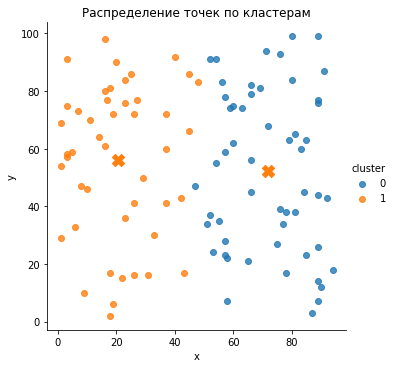

In [45]:
op_count = cluster_count(x, y, 0.5)

Оптимальное число кластеров при альфа = 5 равно 24


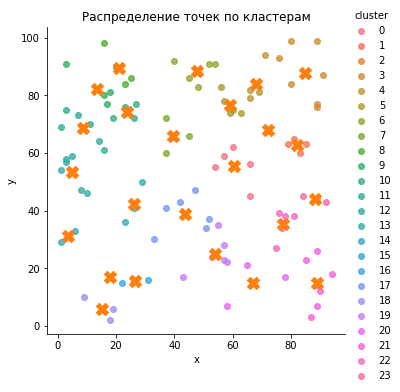

In [46]:
cluster_count_j(x, y, 5)

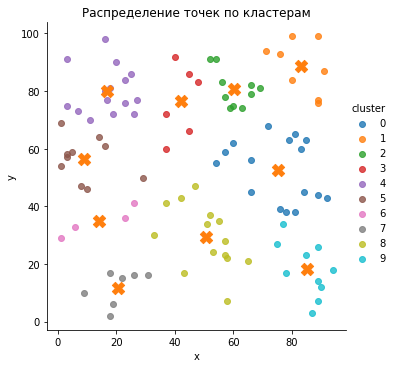

In [47]:
df, x_c, y_c = kmeans(10, x, y, True)

In [53]:
def kmeans2(k, x, y, sh_grph):
    n = len(x)
    df = pd.DataFrame()
    df['x'] = x
    df['y'] = y
    df['cluster'] = [0] * n
    if sh_grph: draw_c(df, 'x', 'y', 'cluster', None, None, '')
    x_c, y_c = centers_init(df['x'], df['y'], k)
    if sh_grph: draw_c(df, 'x', 'y', 'cluster', x_c, y_c, 'Начальные центры кластеров')
    while True:
        clusters = cluster(k, df['x'], df['y'], x_c, y_c)
        if np.array_equal(clusters, df['cluster']):
            break
        else:
            df['cluster'] = clusters
            if sh_grph: draw_c(df, 'x', 'y', 'cluster', x_c, y_c, 'Распределение точек по кластерам')
            centers_c(df['x'], df['y'], x_c, y_c, clusters, k)
            if sh_grph: draw_c(df, 'x', 'y', 'cluster', x_c, y_c, 'Перемещение центров кластеров')
    return df, x_c, y_c
def cluster_count2(x, y):
    d = []
    df, x_c, y_c = kmeans2(1, x, y, False)
    j_pp = sum_sqr(1, df, x_c, y_c)
    df, x_c, y_c = kmeans2(2, x, y, False)
    j_p = sum_sqr(2, df, x_c, y_c)
    for k in range(3, len(x)):
        df, x_c, y_c = kmeans2(k, x, y, False)
        j = sum_sqr(k, df, x_c, y_c)
        d.append(np.abs((j_p - j)/(j_pp - j_p)))
        j_pp = j_p
        j_p = j
    min_d = min(d)
    return [j + 2 for j in range(len(d)) if d[j] == min(d)]
def cluster_count_j2(x, y, alpha):
    df, x_c, y_c = kmeans2(1, x, y, False)
    old_j = sum_sqr(1, df, x_c, y_c)
    for k in range(2, 50):
        df, x_c, y_c = kmeans2(k, x, y, False)
        j = sum_sqr(k, df, x_c, y_c)
        if old_j - j <= alpha:
            return k
        old_j = j
    return len(x)

In [54]:
cluster_count2(x, y)

[93]

In [55]:
cluster_count_j2(x, y, 5)

24

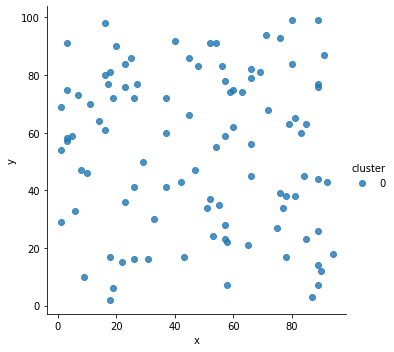

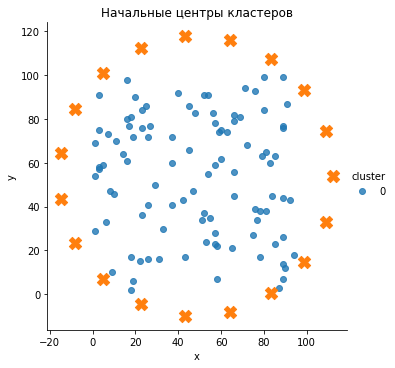

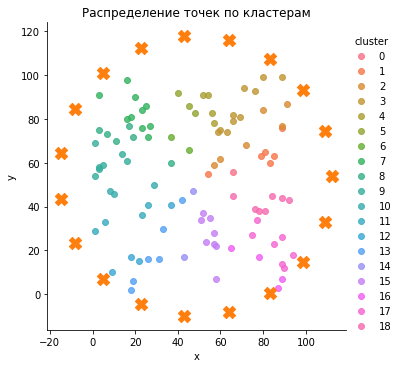

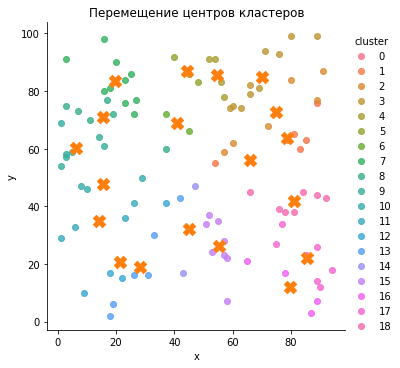

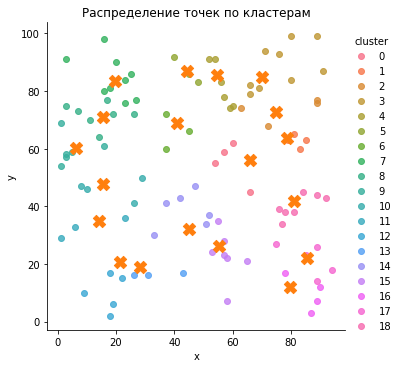

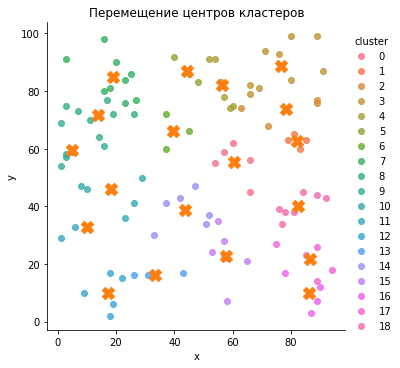

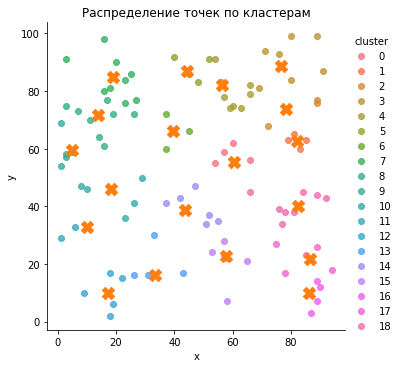

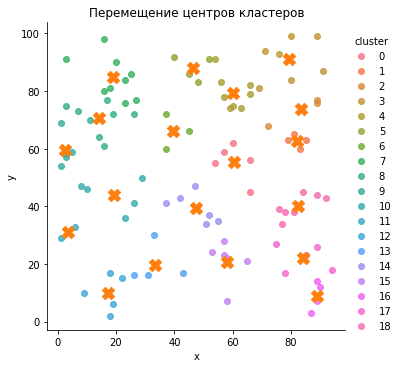

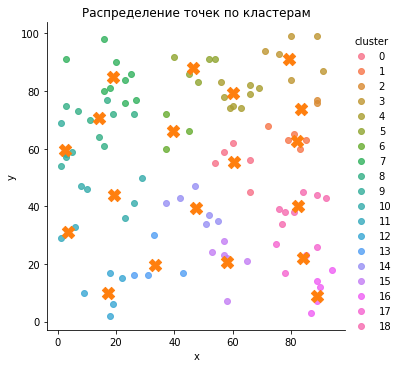

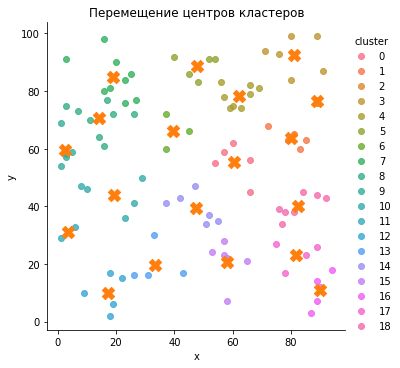

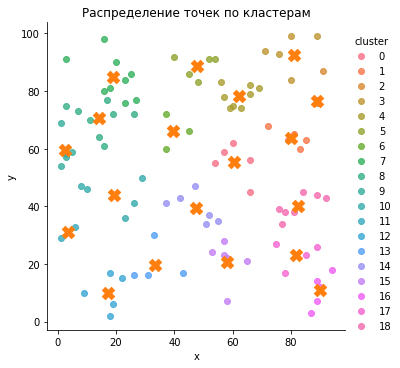

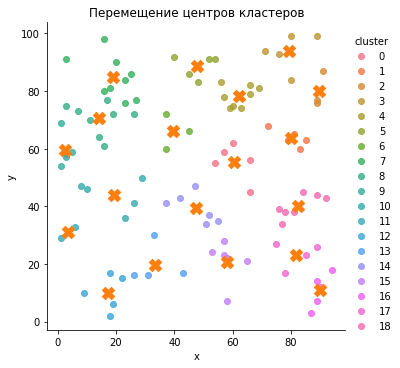

In [56]:
df, x_c, y_c = kmeans2(19, x, y, True)

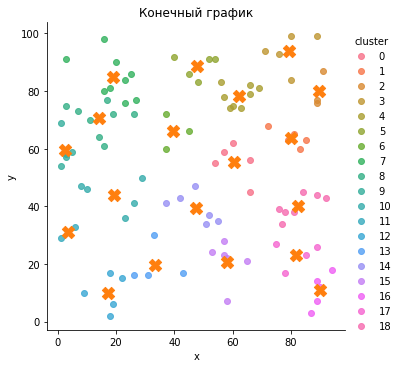

In [52]:
draw_c(df, 'x', 'y', 'cluster', x_c, y_c, 'Конечный график')